In this notebook, useful data loading and transforming functions are demonstrated.  The main sources of data are Quandl, Cryptocompare and Yahoo Finance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
import itertools
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import quandl

In [3]:
from utils import *

# Quandl

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

## Exchange Data International

One may use [_Exchange Data International_](https://www.quandl.com/publishers/edi) free sample series as follows:

In [ ]:
print(os.listdir(QUANDL_PATH))

In [ ]:
# prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()), download=True, verbose=True)
prices_dict = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))
print(len(prices_dict))
print(list(prices_dict.keys()))

In [ ]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()

In [ ]:
prices_dict[ticker_j].head(5)

##  Sharadar Equity Prices

One may use [_Sharadar Equity Prices_](https://www.quandl.com/publishers/sharadar) free sample series as follows:

In [5]:
# tickers, prices = get_quandl_sharadar(download=True)  # The first time...
tickers, prices = get_quandl_sharadar(free=False)

In [6]:
print('Number of price series:', len(tickers))

Number of price series: 12871


j: 10380  -  BCL1


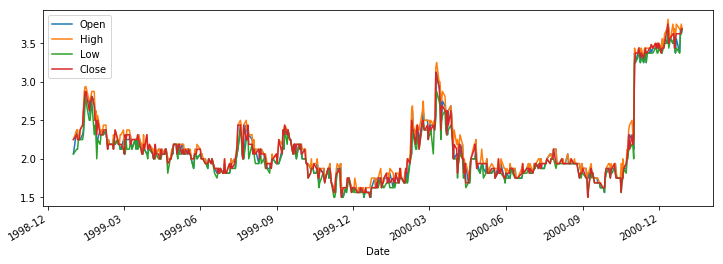

In [7]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = get_price_j(ticker_j, prices)
price_j[['Open', 'High', 'Low', 'Close']].plot();

In [8]:
price_j

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Date,,,,,,,,
1998-12-31,2.063,2.250,2.063,2.250,37600.0,0.0,2.250,2018-04-04
1999-01-04,2.375,2.375,2.125,2.313,8500.0,0.0,2.313,2018-04-04
1999-01-05,2.313,2.375,2.125,2.250,13900.0,0.0,2.250,2018-04-04
1999-01-06,2.250,2.250,2.250,2.250,4500.0,0.0,2.250,2018-04-04
1999-01-07,2.250,2.250,2.250,2.250,100.0,0.0,2.250,2018-04-04
...,...,...,...,...,...,...,...,...
2000-12-22,3.563,3.750,3.438,3.625,28300.0,0.0,3.625,2018-04-04
2000-12-26,3.375,3.688,3.375,3.625,133800.0,0.0,3.625,2018-04-04
2000-12-27,3.688,3.688,3.625,3.625,12500.0,0.0,3.625,2018-04-04


### Train, Dev, Test samples 

In [9]:
N = len(tickers)
train, dev = 6 * N // 10, 2 * N // 10
test = N - train - dev
print('N:', N, ', Tain:', train, ', Dev:', dev, ', Test:', test)

N: 12871 , Tain: 7722 , Dev: 2574 , Test: 2575


In [10]:
np.random.seed(123)
tickers_full = list(np.random.permutation(tickers))
tickers_train = tickers_full[:train]
tickers_dev = tickers_full[train:(train + dev)]
tickers_test = tickers_full[-test:]
assert len(tickers_train + tickers_dev + tickers_test) == N

In [ ]:
prices_train = prices.loc[tickers_train]
prices_train.reset_index().to_feather(fname='input/Quandl/sharadar_train.feather')

In [ ]:
prices_dev = prices.loc[tickers_dev]
prices_dev.reset_index().to_feather(fname='input/Quandl/sharadar_dev.feather')

In [ ]:
prices__test = prices.loc[tickers__test]
prices__test.reset_index().to_feather(fname='input/Quandl/sharadar__test.feather')

## Cryptocompare

## Yahoo Finance

## Data pre-processing 

# Data Cleaning

* OHLC: open and close within [low, high].

## Data Transforms

* Weekly and monthly OHLC prices.
* Zero volume days.
* Returns.
* Technical Indicators (volatility, skewness, etc.)

In [ ]:
weekly_j = daily_to_weekly_prices(price_j)

In [ ]:
weekly_j[['Open', 'High', 'Low', 'Close']].plot();